In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.autograd import Variable

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


from math import sqrt

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [12]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

### Data Exploration

In [27]:
df = pd.read_csv("Electric_Production.csv", index_col='DATE', parse_dates=True)
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [61]:
df.isnull().sum()
df.columns = ['value']

In [62]:
df.tail()

,value
DATE,
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359
2017-12-01,114.7212
2018-01-01,129.4048


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   IPG2211A2N  397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


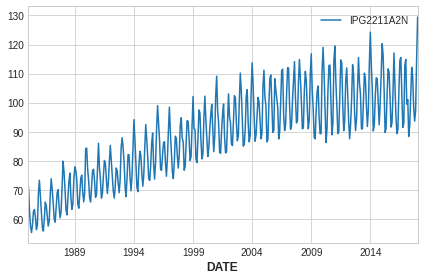

In [31]:
df.plot()

**The data can be interpreted as a time series with a clear positive trend and seasonality.
In the following, prediction models by LSTM and RNN will be developed to forecast the time series.**bold text**

### PyTorch LSTM RNN


**The first thing we must do is to properly shape the input data. When modeling a time series by LSTM RNN, it is crucial to to properly shape the input data in a sliding windows format. In this application, the data is given as monthly data. So, for example, we can use a 12 steps prediction window. This means that we use 12 samples of data (data of an entire year) to predict the 13th sample.**

In [32]:
prediction_window=12

In [33]:
n_input=12
n_features=1

In [34]:
train = df.copy()
train.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [35]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)

In [36]:
def sliding_windows(data, n_input):
    X_train=[]
    y_train=[]
    for i in range(n_input,len(data)):
        X_train.append(data[i-n_input:i])
        y_train.append(data[i])
    return np.array(X_train), np.array(y_train)

In [37]:
x, y = sliding_windows(scaled_train, prediction_window)

In [38]:
print(f'Given the Array: \n {x[0].flatten()}')
print(f'Predict this value: \n {y[0]}')

Given the Array: 
 [0.23201741 0.20727443 0.09630353 0.02910391 0.         0.03745865
 0.09859805 0.10707831 0.07112325 0.0135012  0.03624525 0.18085375]
Predict this value: 
 [0.24282188]


In [39]:
train_size = int(len(train) - prediction_window*3)
val_size = len(train) - train_size

In [40]:
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

X_train = Variable(torch.Tensor(np.array(x[:train_size])))
y_train = Variable(torch.Tensor(np.array(y[:train_size])))

X_valid = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
y_valid = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

### LSTM Modelling

In [41]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True
        )
        
        self.fc1 = nn.Linear(hidden_size,40)
        self.fc2 = nn.Linear(40,1)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        _, (h_out,_) = self.lstm(x, (h0,c0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc2(self.relu(self.fc1(h_out)))
        
        return out

In [42]:
EPOCHS = 2000
LEARNING_RATE = 0.008
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

INPUT_SIZE = n_features
HIDDEN_SIZE = 100
NUM_LAYERS = 1

In [43]:
model = LSTMNet(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS)
model.to(DEVICE)
print(model)

LSTMNet(
  (lstm): LSTM(1, 100, batch_first=True)
  (fc1): Linear(in_features=100, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=1, bias=True)
  (relu): ReLU()
)


In [44]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

LSTM Training Loop

In [45]:
early_stopping_patience = 150
early_stopping_counter = 0

valid_loss_min=np.inf

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    model.train()
    output = model(X_train)
    
    train_loss = criterion(output, y_train)
    
    train_loss.backward()
    optimizer.step()
    
    
    with torch.no_grad():
        model.eval()
        output_val = model(X_valid)
        valid_loss = criterion(output_val, y_valid)
        
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), './state_dict.pt')
            print(f'Epoch {epoch + 0:01}: Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
            valid_loss_min = valid_loss
            early_stopping_counter=0 #reset counter if validation loss decreases
        else:
            print(f'Epoch {epoch + 0:01}: Validation loss did not decrease')
            early_stopping_counter+=1

        if early_stopping_counter > early_stopping_patience:
            print('Early stopped at epoch :', epoch)
            break

        print(f'\t Train_Loss: {train_loss:.4f} Val_Loss: {valid_loss:.4f}  BEST VAL Loss: {valid_loss_min:.4f}\n')

Epoch 0: Validation loss decreased (inf --> 0.231942).  Saving model ...
	 Train_Loss: 0.1979 Val_Loss: 0.2319  BEST VAL Loss: 0.2319

Epoch 1: Validation loss decreased (0.231942 --> 0.083424).  Saving model ...
	 Train_Loss: 0.1135 Val_Loss: 0.0834  BEST VAL Loss: 0.0834

Epoch 2: Validation loss did not decrease
	 Train_Loss: 0.0406 Val_Loss: 0.2549  BEST VAL Loss: 0.0834

Epoch 3: Validation loss decreased (0.083424 --> 0.033703).  Saving model ...
	 Train_Loss: 0.4013 Val_Loss: 0.0337  BEST VAL Loss: 0.0337

Epoch 4: Validation loss did not decrease
	 Train_Loss: 0.0352 Val_Loss: 0.1203  BEST VAL Loss: 0.0337

Epoch 5: Validation loss did not decrease
	 Train_Loss: 0.0549 Val_Loss: 0.1733  BEST VAL Loss: 0.0337

Epoch 6: Validation loss did not decrease
	 Train_Loss: 0.0804 Val_Loss: 0.1981  BEST VAL Loss: 0.0337

Epoch 7: Validation loss did not decrease
	 Train_Loss: 0.0937 Val_Loss: 0.2072  BEST VAL Loss: 0.0337

Epoch 8: Validation loss did not decrease
	 Train_Loss: 0.0988 Va

### LSTM Prediction

In [46]:
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

In [47]:
valid_predict = model(X_valid)
y_pred_scaled = valid_predict.data.numpy()
y_pred = scaler.inverse_transform(y_pred_scaled)

In [48]:
df_pred=train.iloc[-24:]
df_pred['prediction']=y_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


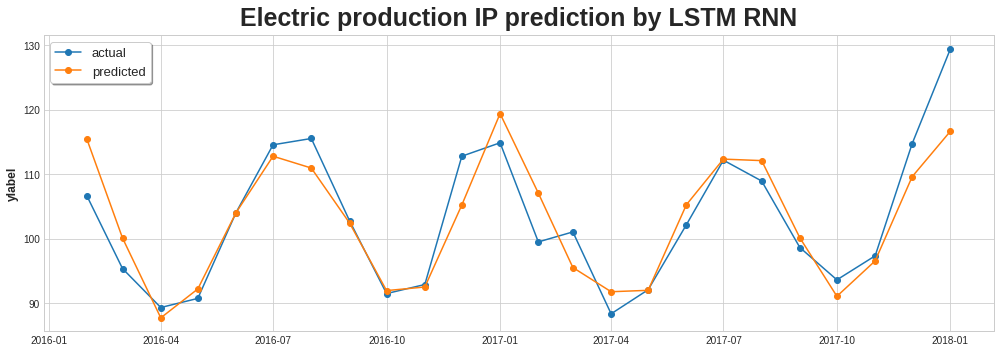

In [50]:
plt.figure(figsize=(14,5))
plt.plot(df_pred.index,df_pred["value"], label="actual", marker="o")
plt.plot(df_pred.index,df_pred["prediction"], label="predicted", marker="o")
plt.title("Electric production IP prediction by LSTM RNN", fontsize=25)
plt.ylabel("ylabel")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.show()

In [52]:
mape_lstm = mape(df_pred["value"], df_pred["prediction"])
print(f"MAPE OF LSTM MODEL : {mape_lstm:.2f} %")

MAPE OF LSTM MODEL : 3.19 %


In [53]:
rmse_lstm = mean_squared_error(df_pred["value"], df_pred["prediction"], squared=False)
print(f"RMSE OF LSTM MODEL : {rmse_lstm:.2f}")

RMSE OF LSTM MODEL : 4.67


LSTM FORECASTING 

In [54]:
test_predictions = []

first_eval_batch = Variable(torch.Tensor(scaled_train[-n_input:]))
current_batch=first_eval_batch.reshape((1,n_input,n_features)) 
for i in range(len(scaled_train[-n_input:])):
    
    current_pred = model(current_batch)
   
    test_predictions.append(current_pred)
    
    current_batch = torch.cat((current_batch[:,1:,:],current_pred.reshape(1,1,1)),1)

In [55]:
forec_vals = [val.flatten().item() for val in test_predictions]
forec_vals = np.array(forec_vals).reshape(-1,1)
forec_vals = scaler.inverse_transform(forec_vals)

In [56]:
date_offset=12
forecast_dates =  (train.index + pd.DateOffset(months=date_offset))[-date_offset:]
forecast_dates

DatetimeIndex(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)

In [57]:
df_forecast=pd.DataFrame({'date': forecast_dates})
df_forecast.set_index('date', inplace=True)
df_forecast['prediction'] = forec_vals
df_forecast.head(12)

,prediction
date,
2018-02-01,111.600188
2018-03-01,104.651894
2018-04-01,90.502796
2018-05-01,91.616161
2018-06-01,104.341664
2018-07-01,113.397608
2018-08-01,109.638786
2018-09-01,99.691168
2018-10-01,92.679198


In [58]:
df_full=df_pred.append(df_forecast)

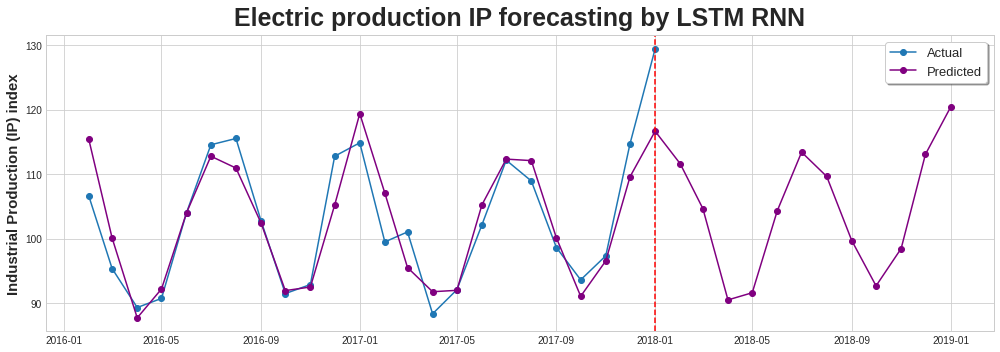

In [60]:

plt.figure(figsize=(14,5))
plt.plot(df_full.index,df_full["value"], label="Actual", marker="o")
plt.plot(df_full.index,df_full["prediction"], label="Predicted", marker="o", color="purple")
plt.axvline(df_pred.index[-1], color="red", linestyle="--")
plt.title("Electric production IP forecasting by LSTM RNN", fontsize=25)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.show()